In [9]:
import numpy as np
import cv2 # OpenCV biblioteka
import matplotlib
import matplotlib.pyplot as plt  

In [10]:
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = 16,12

In [11]:

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 245, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

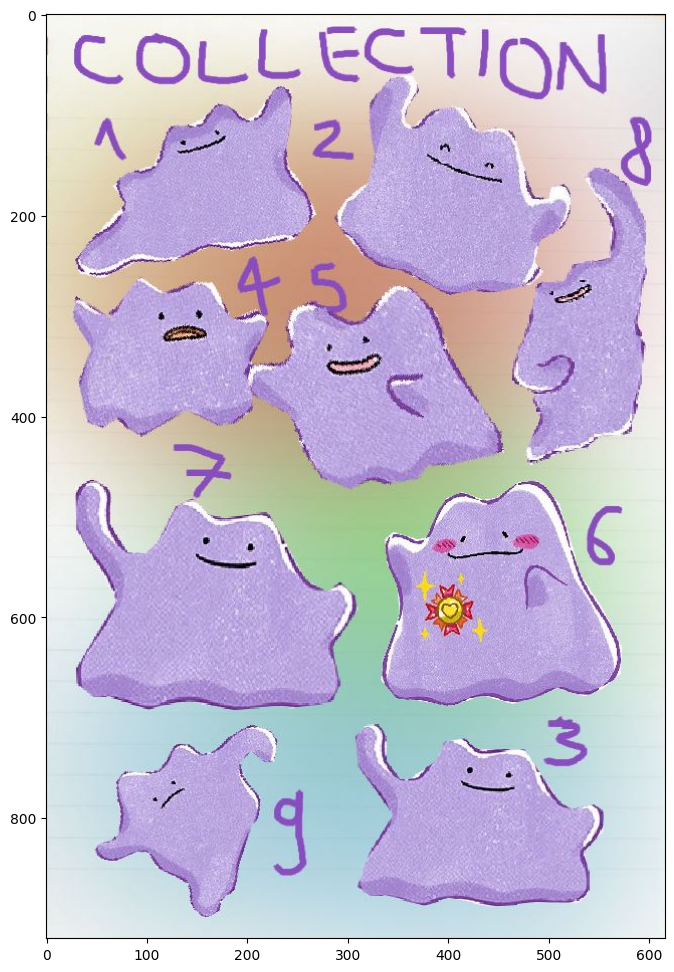

In [220]:
img = load_image('pictures/ditto_v10_notebook.jpg')
img = img[60:980, 284:900]

display_image(img, color=True)

8


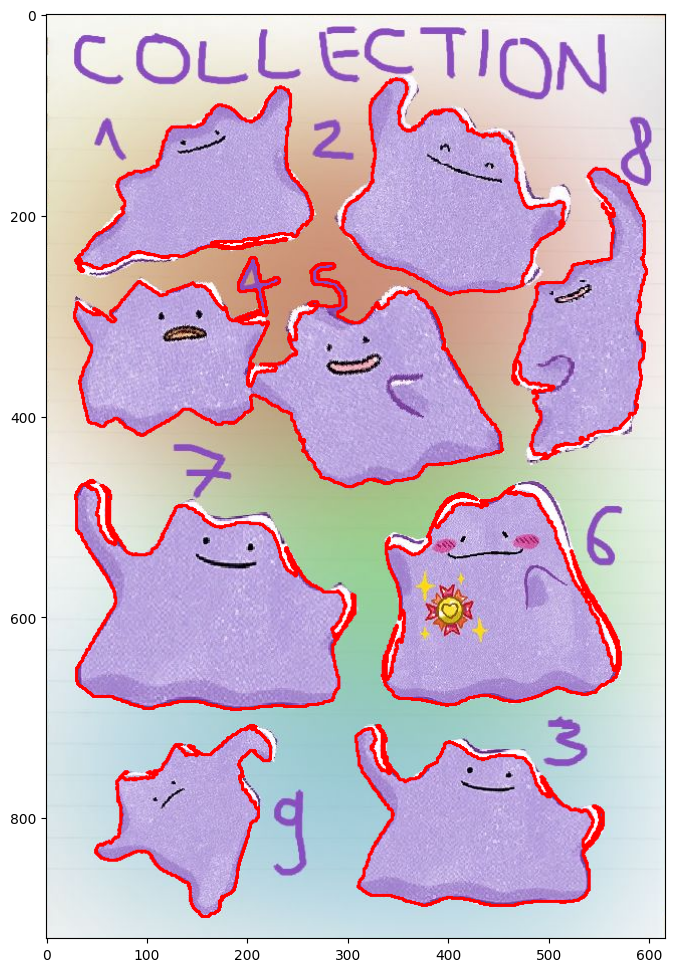

In [221]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#display_image(hsv, color=True)
lower_purple = np.array([120, 50, 50])
upper_purple = np.array([160, 255, 253])
#, upper_purple = get_bounds()
mask = cv2.inRange(hsv, lower_purple, upper_purple)
#display_image(mask)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 4000 
max_area = 130000
filtered_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if min_area < area < max_area:
        filtered_contours.append(contour)

character_count = len(filtered_contours)
img_cont = img.copy()
cv2.drawContours(img_cont, filtered_contours, -1, (255, 0, 0), 2)

display_image(img_cont, color=True)
print(character_count)

(566720, 3)


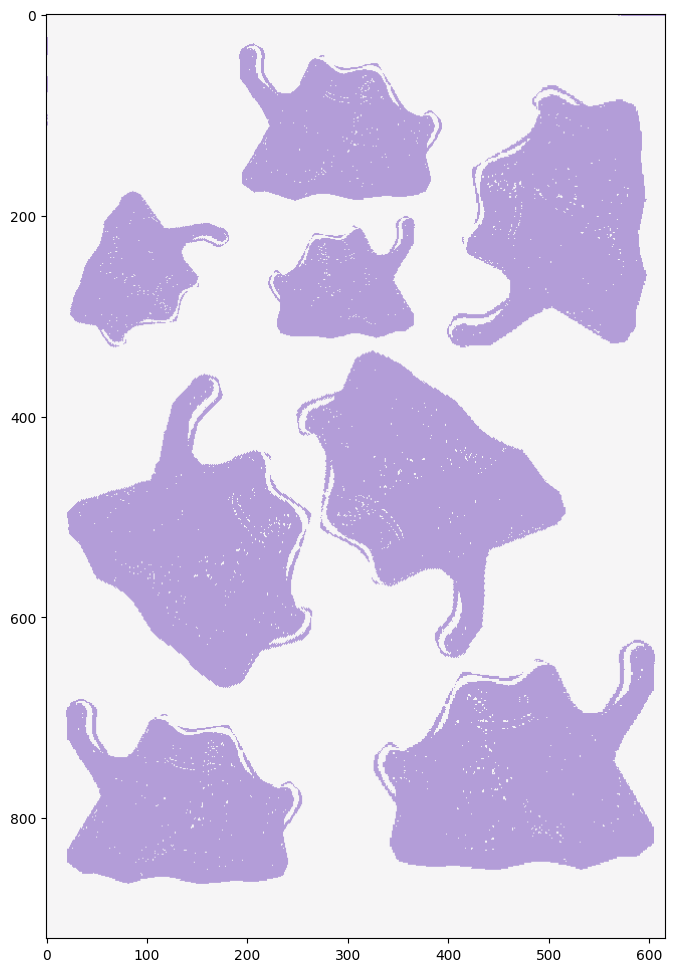

In [15]:
# sliku konvertujemo u 2D niz piksela sa po 3 vrednosti (RGB)
pixel_values = img.reshape((-1,3)) 
# konvertujemo sve u float32
pixel_values = np.float32(pixel_values)
print(pixel_values.shape)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
# mapiramo sve piksele na boju koja odgovara centru klastera
segmented_data = centers[labels.flatten()]
# vraćamo u dimenzije slike
segmented_image = segmented_data.reshape((img.shape))
display_image(segmented_image, color=True)

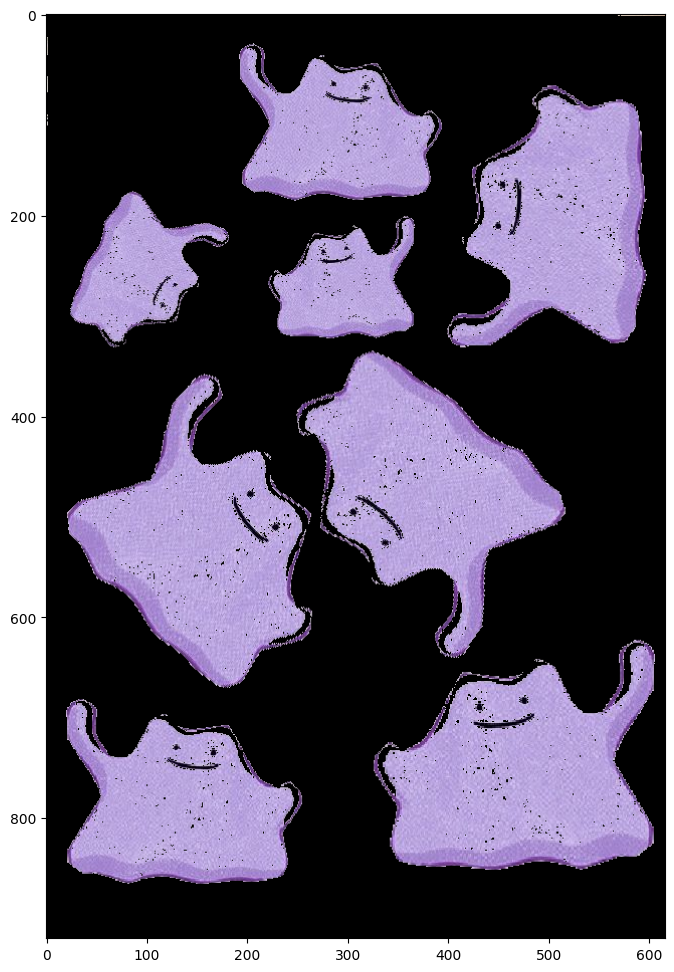

In [16]:
masked_image = np.copy(img)
# sliku konvertujemo u vektor piksela dimenzija Mx3
masked_image = masked_image.reshape((-1, 3))
# biramo koji klaster želimo da izdvojimo
cluster = 1
labels = labels.flatten()
masked_image[labels == 1] = [0, 0, 0]

# vraćamo sliku u početni oblik
masked_image = masked_image.reshape(img.shape)
# masked_image = image_bin(image_gray(masked_image))
# masked_image = 255 - masked_image
display_image(masked_image)

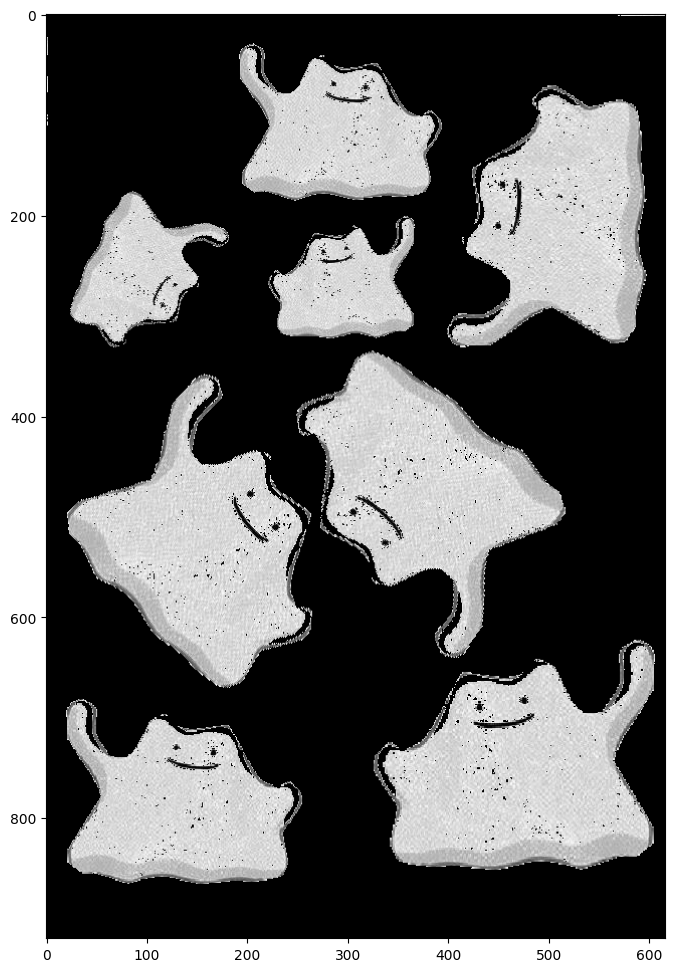

In [17]:
img_gs = image_gray(masked_image)
display_image(img_gs)

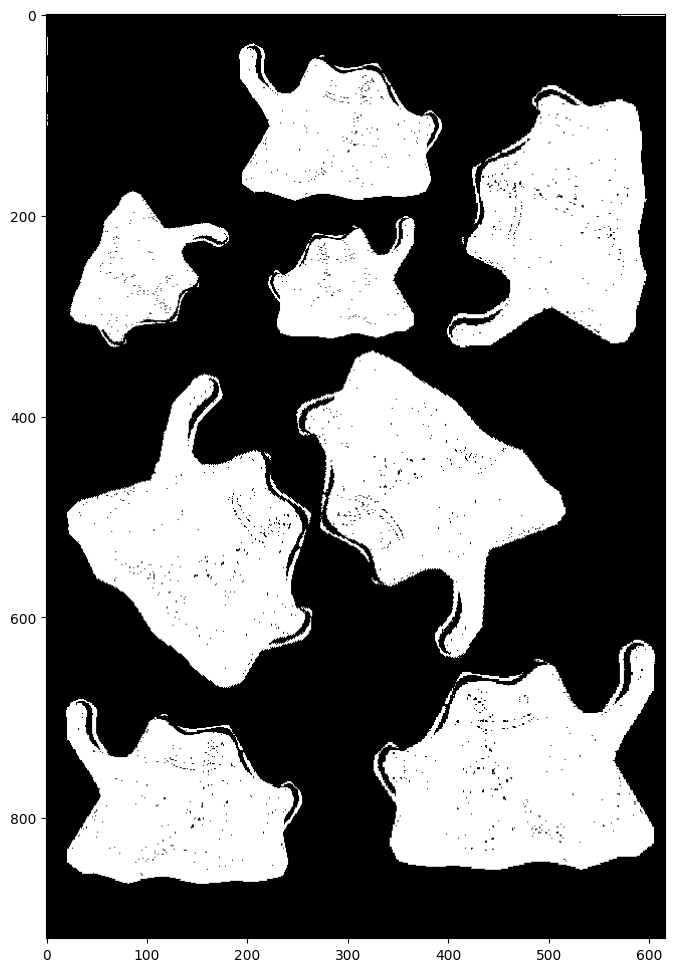

In [18]:
ret, img_bin = cv2.threshold(img_gs, 0, 255, cv2.THRESH_BINARY)
# kernel = np.ones((3,3), np.uint8) # strukturni element 3x3 blok
# opening = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, kernel, iterations = 2) # otvaranje
# opening = opening[63:1000, 288:900]
display_image(img_bin)

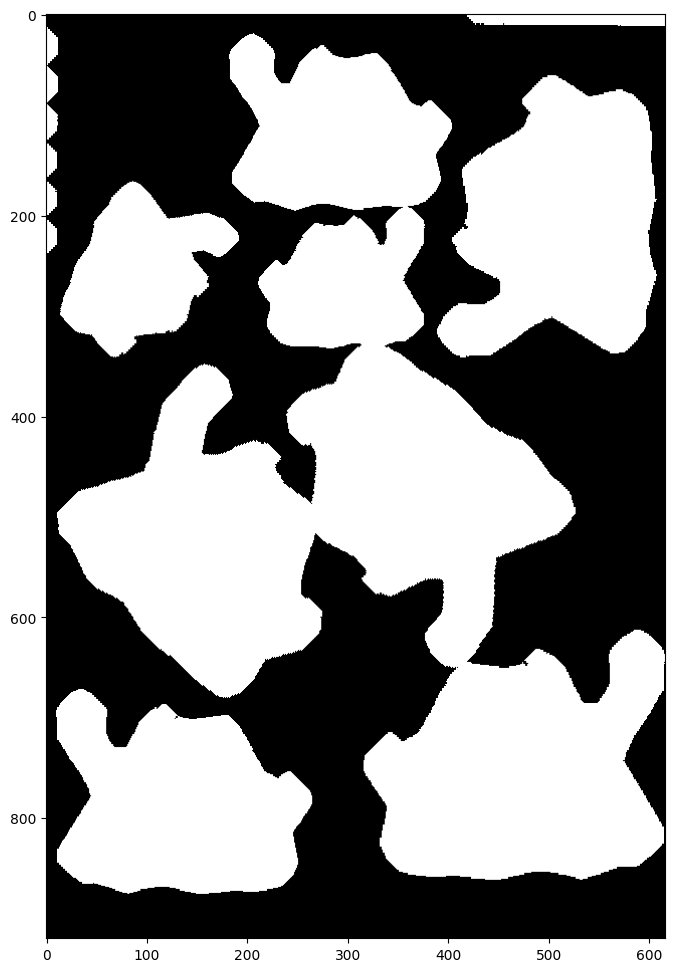

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5)) # MORPH_ELIPSE, MORPH_RECT
img_dil = cv2.dilate(img_bin, kernel, iterations=5)
#img_dil = cv2.erode(img_dil, kernel, iterations=5)
display_image(img_dil)

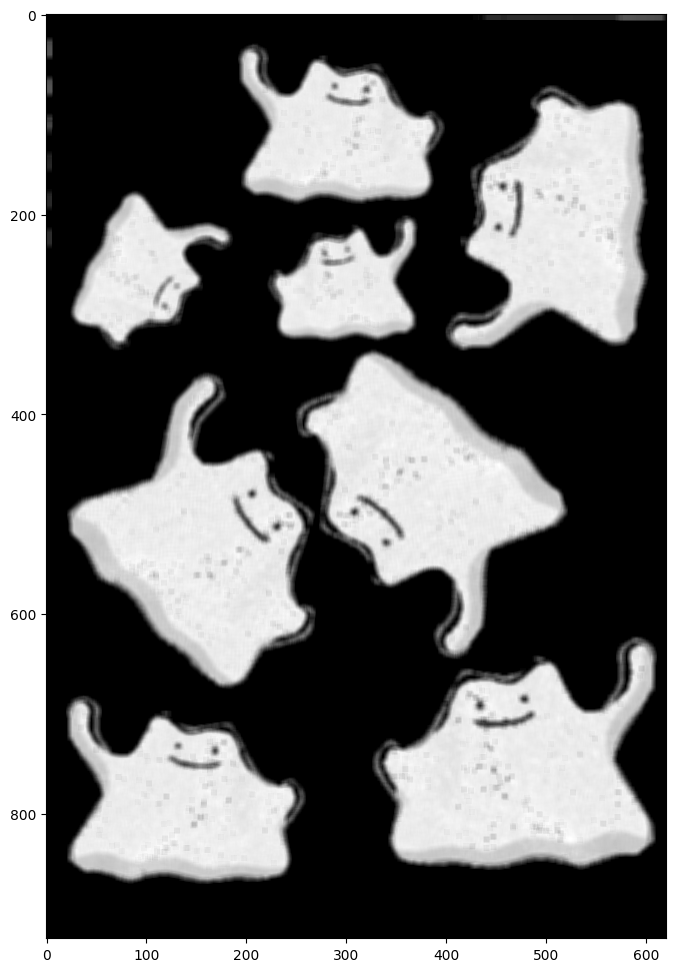

In [20]:
# BLUR
from scipy import signal

k_size = 6
k = (1./k_size*k_size) * np.ones((k_size, k_size))
image_blur = signal.convolve2d(img_gs, k)
plt.imshow(image_blur, 'gray')

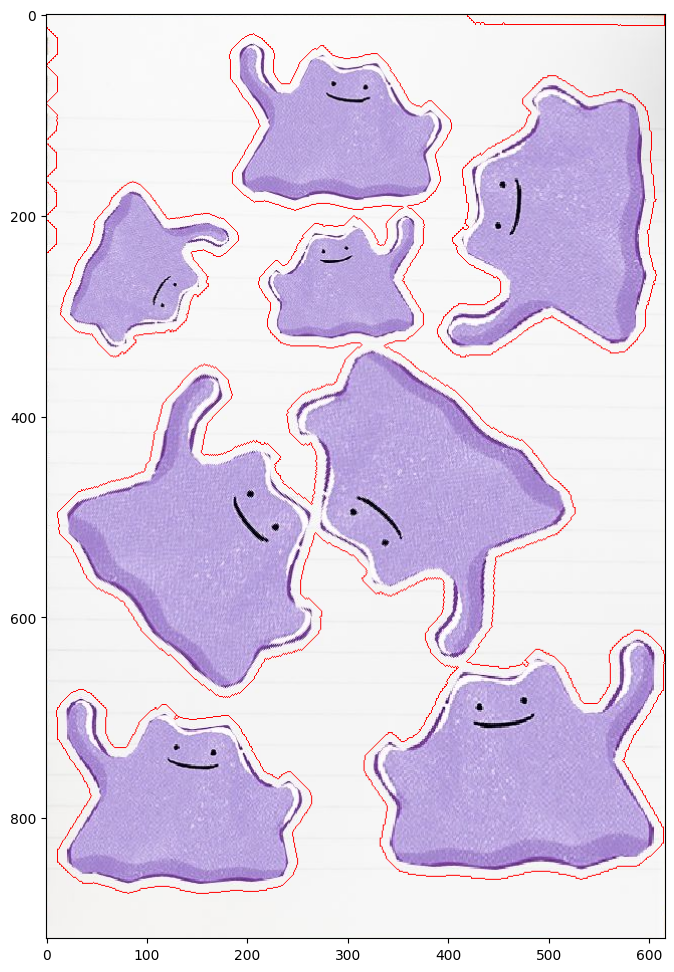

In [21]:
contours, hierarchy = cv2.findContours(img_dil, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
img_cont = img.copy()
cv2.drawContours(img_cont, contours, -1, (255, 0, 0), 1)
plt.imshow(img_cont)

12
3


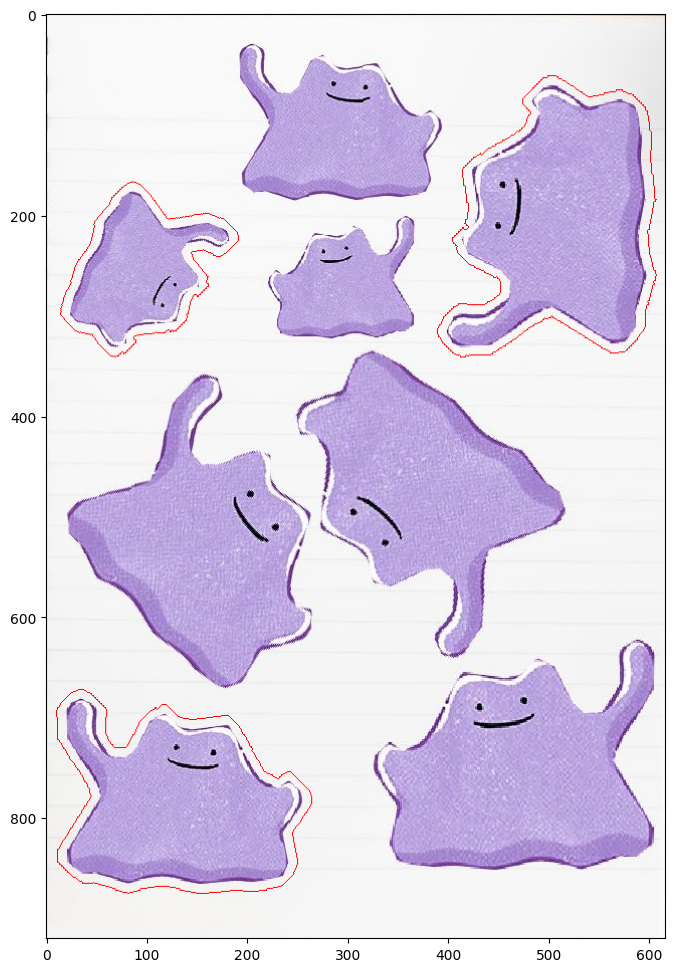

In [22]:
contours_ditto = [] # ovde ce biti samo konture koje pripadaju bar-kodu
print(len(contours))
for contour in contours: # za svaku konturu
    center, size, angle = cv2.minAreaRect(contour) # pronadji pravougaonik minimalne povrsine koji ce obuhvatiti celu konturu
    height, width = size

    if width > 40 and width < 400 and height > 40 and height < 400 : # uslov da kontura pripada bar-kodu
        contours_ditto.append(contour) # ova kontura pripada bar-kodu

img_final = img.copy()
cv2.drawContours(img_final, contours_ditto, -1, (255, 0, 0), 1)
print(len(contours_ditto))
plt.imshow(img_final)